01/03 : EfficientNet epoch 20 + epoch 20 더 돌려서 제출  
 - 등수: 21등, 점수: 0.83261

## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import timm
from torchvision import transforms

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':64,
    'NUM_WORKERS':0, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load & Train/Validation Split

In [5]:
df = pd.read_csv('./train.csv')

In [6]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]

In [7]:
# 제공된 학습데이터 중 2글자 이상의 샘플들에 대해서 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df, df['len'], test_size=0.2, random_state=CFG['SEED'])

In [8]:
# 학습 데이터로 우선 배치한 1글자 샘플들과 분할된 2글자 이상의 학습 샘플을 concat하여 최종 학습 데이터로 사용
train = pd.concat([train_v1, train_v2])
print(len(train), len(val))

66251 10637


## Get Vocabulary

In [9]:
# 학습 데이터로부터 단어 사전(Vocabulary) 구축
train_gt = [gt for gt in train['label']]
train_gt = "".join(train_gt)
letters = sorted(list(set(list(train_gt))))
print(len(letters))

2349


In [10]:
vocabulary = ["-"] + letters
print(len(vocabulary))
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
char2idx = {v:k for k,v in idx2char.items()}

2350


## CustomDataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        image = Image.open(self.img_path_list[index]).convert('RGB')
        
        if self.train_mode:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
            
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
    
    # Image Augmentation
    def train_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_WIDTH_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def test_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_WIDTH_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [12]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

val_dataset = CustomDataset(val['img_path'].values, val['label'].values)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

In [44]:
len(train_dataset)

66251

In [13]:
len(train_dataset)

66251

In [14]:
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)

torch.Size([64, 3, 224, 224]) ('신비', '그나마', '씻기다', '쉴', '일반', '셋', '수입되다', '세', '달리다', '뜁', '선원', '추가', '대량', '예매하다', '콩', '쯩', '못', '사모님', '뱀', '호주머니', '젤', '벌', '불', '베개', '수도권', '회복되다', '날씨', '유산', '견해', '체조', '얘', '튀김', '삼계탕', '어려움', '세', '발자국', '터', '함께', '스타', '샛', '참여하다', '븐', '학생증', '신인', '신청', '양복', '추진하다', '집중하다', '구분되다', '기타', '지구', '꽐', '명예', '대륙', '천장', '신', '칡', '창조', '걋', '나무', '향', '여행사', '강', '흄')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


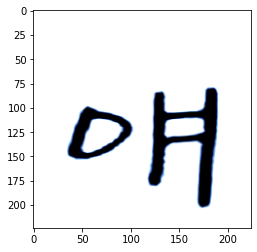

In [51]:
import matplotlib.pyplot as plt
plt.imshow(image_batch[30].permute(1,2,0))

## Model Define

In [16]:
class RecognitionModel(nn.Module):
    def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256):
        super(RecognitionModel, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
    
        # CNN Backbone = 사전학습된 Efficientnet 활용
        # https://arxiv.org/abs/1905.11946
        eff0 = timm.create_model(model_name='efficientnet_b0', pretrained=True)
        # CNN Feature Extract
        #eff_modules = list(eff.children())[:-4]
        eff_modules = list(eff0.children())[:-2]
        self.feature_extract = nn.Sequential(
            *eff_modules,
            
        )
        
        self.linear1 = nn.Linear(8960, rnn_hidden_size)
        
        # RNN
        self.rnn = nn.RNN(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
    def forward(self, x):

        
        # CNN
        x = self.feature_extract(x) # [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
         
        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        x = self.linear1(x)
        
        # RNN
        x, hidden = self.rnn(x)
        
        output = self.linear2(x)
        output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
        return output

## Define CTC Loss

In [17]:
criterion = nn.CTCLoss(blank=0) # idx 0 : '-'

In [18]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [19]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

## Train

In [20]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    best_loss = 999999
    best_model = None
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        _val_loss = validation(model, val_loader, device)
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model
    
    return best_model

## Validation

In [21]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            loss = compute_loss(text_batch, text_batch_logits)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

## Run!!

In [22]:
model = RecognitionModel()
model.eval()

optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [1] Train CTC Loss : [3.90993] Val CTC Loss : [0.83351]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [2] Train CTC Loss : [1.11476] Val CTC Loss : [0.46645]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [3] Train CTC Loss : [0.58082] Val CTC Loss : [0.37927]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [4] Train CTC Loss : [0.40130] Val CTC Loss : [0.26390]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [5] Train CTC Loss : [0.35367] Val CTC Loss : [0.23031]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [6] Train CTC Loss : [0.32245] Val CTC Loss : [0.28172]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [7] Train CTC Loss : [0.30127] Val CTC Loss : [0.22648]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [8] Train CTC Loss : [0.29656] Val CTC Loss : [0.25141]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [9] Train CTC Loss : [0.27739] Val CTC Loss : [0.25429]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [10] Train CTC Loss : [0.28032] Val CTC Loss : [0.27561]
Epoch    10: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [11] Train CTC Loss : [0.09328] Val CTC Loss : [0.11176]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [12] Train CTC Loss : [0.06334] Val CTC Loss : [0.11611]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [13] Train CTC Loss : [0.08563] Val CTC Loss : [0.12694]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [14] Train CTC Loss : [0.06471] Val CTC Loss : [0.12398]
Epoch    14: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [15] Train CTC Loss : [0.03168] Val CTC Loss : [0.08340]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [16] Train CTC Loss : [0.02081] Val CTC Loss : [0.08320]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [17] Train CTC Loss : [0.01731] Val CTC Loss : [0.07982]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [18] Train CTC Loss : [0.01957] Val CTC Loss : [0.08158]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [19] Train CTC Loss : [0.01517] Val CTC Loss : [0.08221]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [20] Train CTC Loss : [0.01621] Val CTC Loss : [0.07868]


In [72]:
torch.save(infer_model.state_dict(), 'model.pt')

In [35]:
# epoch 20 추가
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [1] Train CTC Loss : [0.00057] Val CTC Loss : [0.05465]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [2] Train CTC Loss : [0.00047] Val CTC Loss : [0.05332]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [3] Train CTC Loss : [0.00082] Val CTC Loss : [0.05555]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [4] Train CTC Loss : [0.00035] Val CTC Loss : [0.05469]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [5] Train CTC Loss : [0.00034] Val CTC Loss : [0.05428]
Epoch    45: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [6] Train CTC Loss : [0.00037] Val CTC Loss : [0.05571]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [7] Train CTC Loss : [0.00027] Val CTC Loss : [0.05564]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [8] Train CTC Loss : [0.00025] Val CTC Loss : [0.05306]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [9] Train CTC Loss : [0.00020] Val CTC Loss : [0.05405]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [10] Train CTC Loss : [0.00025] Val CTC Loss : [0.05318]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [11] Train CTC Loss : [0.00022] Val CTC Loss : [0.05296]
Epoch    51: reducing learning rate of group 0 to 7.8125e-06.


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [12] Train CTC Loss : [0.00074] Val CTC Loss : [0.05292]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [13] Train CTC Loss : [0.00018] Val CTC Loss : [0.05330]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [14] Train CTC Loss : [0.00020] Val CTC Loss : [0.05235]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [15] Train CTC Loss : [0.00018] Val CTC Loss : [0.05310]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [16] Train CTC Loss : [0.00023] Val CTC Loss : [0.05337]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [17] Train CTC Loss : [0.00018] Val CTC Loss : [0.05373]
Epoch    57: reducing learning rate of group 0 to 3.9063e-06.


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [18] Train CTC Loss : [0.00016] Val CTC Loss : [0.05378]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [19] Train CTC Loss : [0.00014] Val CTC Loss : [0.05291]


  0%|          | 0/1036 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch : [20] Train CTC Loss : [0.00016] Val CTC Loss : [0.05331]
Epoch    60: reducing learning rate of group 0 to 1.9531e-06.


In [25]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/model.pt'))
# model.eval()
# model = model.to(device)

## Inference

In [26]:
test = pd.read_csv('./test.csv')

In [27]:
test_dataset = CustomDataset(test['img_path'].values, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


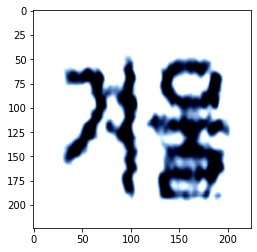

In [71]:
plt.imshow(test_dataset[25].permute(1,2,0))

In [28]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for image_batch in tqdm(iter(test_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            preds.extend(text_batch_pred)
    return preds

In [36]:
predictions = inference(infer_model, test_loader, device)

  0%|          | 0/1159 [00:00<?, ?it/s]

## Submission

In [30]:
# 샘플 별 추론결과를 독립적으로 후처리
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [37]:
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = predictions
submit['label'] = submit['label'].apply(correct_prediction)

In [38]:
submit.to_csv('./submission.csv', index=False)